**DR Vision**

This project leverages transfer learning and ensembling techniques in order to classify varying stages of diabetic retinopathy (0 - No DR, 1 - Mild, 2 - Moderate, 3 - Severe, 4 - Proliferative DR).
There were 2 datasets used in this project. The first includes approximately 35000 retina images from a 2015 Kaggle competition called 'Diabetic Retinopathy Detection'. These images were used to pretrain a base model.
The next dataset includes 4700 retina images from the 'ATPOS 2019 Blindness Detection' challenge.

A variety of techniques were used throughout this project. First, I pretrained an EfficientNet B3 model using transfer learning on the first dataset due to the abundance of data availalbe.
Then, I created 4 models with different combinations of image preprocessing and augmentations in order to mimic possible variations of retina images. These 4 models were finetuned on 80% of the 2019 data, using the remaining 20% as the cross validation set.

Finally, test time augmentation (TTA) was used for each image during inference. In particular, 90 degree rotations, vertical and horizontal flips were applied to each image. This results in 4 predictions for each model, which were averaged to obtain one model's final prediction.
Then, the final predictions for each sample are averaged to decide on the final class. A test set was created, as the cross validation set was used to optimize for the best performing threshold.

We observe that the final model achieves an 86% test set accuracy.

In [ ]:
!pip install kaggle
!pip install torch torchvision
!pip install efficientnet_pytorch
!pip install albumentations

In [ ]:
#The following cell is to setup my environment and extract the images/labels form the 2015 dataset first

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c diabetic-retinopathy-detection
!unzip diabetic-retinopathy-detection.zip
!sudo apt-get install -y p7zip-full
!cat train.zip.* > combined_train.zip
!7z e -otrain_images combined_train.zip

In [ ]:
# the following commands extract the 2019 data

!kaggle competitions download -c aptos2019-blindness-detection
!unzip ../aptos2019-blindness-detection.zip

In [ ]:
#unzip the large train file and extract all contents in current directory

with zipfile.ZipFile('trainLabels.csv.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
# data manipulation and processing
import pandas as pd
import numpy as np
import zipfile
from PIL import Image
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# deep learning and image processing
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import torch.nn as nn
import cv2
from efficientnet_pytorch import EfficientNet

# model evaluation and utilities
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import copy

# reading 2015 CSV file
train_CSV_2015 = pd.read_csv('trainLabels.csv')


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #set the device variable

Before defining the training datasets and dataloaders, I'd like to explain the methodolody used for this problem. Since the diabetic retinopathy classification data is in stages, it's worse to classify a 3rd stage image as class 1 vs class 2. Thus, we need to adjust the loss function and labels used in standard classification.

The idea is to take the label and create a vector of length = # of classes. If the class is 0, the resulting vector for ordinal classification will be [1, 0, 0, 0, 0]. If the class is 1, the vector should be [1, 1, 0, 0, 0]. If the class is 4, the vector should be [1, 1, 1, 1, 1]. This way, classes farther apart on the disease progression scale also have very distinc labels are not treated as discrete classes.

Our models include output layers with 5 units and make use of the sigmoid activation function in order to produce numbers between 0 and 1 (eg. output could be [0.9, 0.8, 0.7, 0.2, 0.1]). Then, binary cross entropy loss is used to compare the value for each class. The resulting 5 losses are then averaged.

In [ ]:
class TrainData2015(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, preprocessing=None):
        self.img_labels = dataframe.sort_values('image')['level'].values #sort the images by the column 'image' and obtain the labels from the column 'level'
        self.img_dir = img_dir
        self.img_names = [img for img in sorted(os.listdir(img_dir)) if img.endswith('.jpeg') and os.path.splitext(img)[0] in dataframe['image'].values] #sort the image directory as well to align image labels and image names (eventually used to read the images)
        self.transform = transform
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx): # function to yield examples during training
        img_path = os.path.join(self.img_dir, self.img_names[idx]) # get image path

        if self.preprocessing:
            image = self.preprocessing(img_path) # custom preprocessing
        else:
            image = cv2.imread(img_path) # default preprocessing using OpenCV
            image = cv2.resize(image, (300, 300))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image) # apply transformations

        label = self.img_labels[idx]
        binary_label = [1 if i <= label else 0 for i in range(5)] # transform into binary label for ordinal classification problem
        binary_label = torch.tensor(binary_label, dtype=torch.float32)

        return image, binary_label

transform = transforms.Compose([
    transforms.ToTensor(),  # transform images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalize
])

train_dataset_2015 = TrainData2015(dataframe=train_CSV_2015, img_dir='2015_train_images', transform=transform)
train_dataloader_2015 = DataLoader(train_dataset_2015, batch_size=32, shuffle=True) #create custom dataloader from PyTorch dataset with shuffling and batch size = 32

In [ ]:
train_CSV_2019 = pd.read_csv('2019_data/train.csv') # reading the 2019 data

class TrainData2019(TrainData2015):
    def __init__(self, dataframe, img_dir, transform=None, preprocessing = None):
        self.img_labels = dataframe.sort_values('id_code')['diagnosis'].values #changing the column values to 'id_code' and 'diagnosis', rest of class is same
        self.img_dir = img_dir
        self.img_names = [img for img in sorted(os.listdir(img_dir)) if img.endswith('.png') and os.path.splitext(img)[0] in dataframe['id_code'].values]
        self.transform = transform
        self.preprocessing = preprocessing

train_dataset_2019 = TrainData2019(dataframe=train_CSV_2019, img_dir='2019_data/train_images', transform=transform)
train_dataloader_2019 = DataLoader(train_dataset_2019, batch_size=32, shuffle=False)  # no need to shuffle for evaluation

In [ ]:
#Early stopping class used to optimize accuracy on the cross validation set

class EarlyStopping:
    def __init__(self, path, patience=3):
        self.patience = patience #patience is how many training epochs without an improvement in validation accuracy it takes to stop the model from training
        self.counter = 0 # counter for number of epochs without improvement
        self.best_score = None # best validation score so far
        self.early_stop = False
        self.path = path # saving path

    def decide(self, val_loss, model, optimizer):

        score = val_loss

        if self.best_score is None: #logic to save checkpoint or set early stop variable to True
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer)
        elif score < self.best_score:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer)
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model, optimizer):
        print('Validation loss decreased, saving the model to {}'.format(self.path)) # save the improved models to the path variable
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': self.best_score,
        }, self.path)

In [ ]:
def process_batch(inputs, targets, model, device, criterion=None, optimizer=None): # general function used to process the batch, both in evaluation and training
    inputs = inputs.to(device) # move the inputs and targets to device the model is on
    targets = targets.to(device)

    outputs = model(inputs) # forward prop

    losses = criterion(outputs, targets).mean(dim=1) # calculate the losses and average them along the columns for one training example
    loss = losses.mean() # take the average of all losses for examples in batch

    if optimizer:
        optimizer.zero_grad() # zero accumulated gradients from prev iterations
        loss.backward() # backward prop
        optimizer.step() # update model's params

    total_loss = loss.item() * inputs.size(0) # multiply the average loss over size of batch and add this to total loss of batch. we will divide total loss over all examples by number of examples later

    preds = (outputs > 0.5).float() # get a boolean mask for the predictions
    _, preds = torch.max(preds * torch.arange(0, 5, device=device), dim=1) # multiply prediction array by [0,1,2,3,4]. Then, take the index of the maximum value in the resulting multiplication, which gives predicted class
    _, targets = torch.max(targets * torch.arange(0, 5, device=device), dim=1) # multiply targers array by same and find prediction index
    corrects = torch.sum(preds == targets) # calculate number of correct predictions for the batch

    return total_loss, corrects

In [ ]:
def evaluate(model, dataloader, device, criterion): # used in model evaluation for the cross validation dataloader
    model.eval()
    epoch_loss = 0.0
    epoch_corrects = 0

    for inputs, targets in dataloader:
        with torch.no_grad():
            loss, corrects = process_batch(inputs, targets, model, device, criterion)
        epoch_loss += loss # get total epoch loss
        epoch_corrects += corrects # get total epoch corrects

    epoch_loss = epoch_loss / len(dataloader.dataset) # find avg loss and accuracy
    epoch_acc = epoch_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc


In [ ]:
# custom training loop for the base and finetuned models.

def train_base_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, early_stopping_path, model_checkpoint_path, device, starting_epoch = 0):
    early_stopping_callback = EarlyStopping(path=early_stopping_path, patience=5)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        epoch_corrects = 0

        for i, (inputs, targets) in enumerate(train_dataloader):
            loss, corrects = process_batch(inputs, targets, model, device, criterion, optimizer)
            epoch_loss += loss
            epoch_corrects += corrects

        epoch_loss = epoch_loss / len(train_dataloader.dataset) # get training epoch loss and accuracy
        epoch_acc = epoch_corrects.double() / len(train_dataloader.dataset)

        print('Epoch {}/{} Training Loss: {:.4f} Training Acc: {:.4f}'.format(starting_epoch + epoch, num_epochs, epoch_loss, epoch_acc))

        val_loss, val_acc = evaluate(model, val_dataloader, device, criterion)
        print('Epoch {}/{} Validation Loss: {:.4f} Validation Acc: {:.4f}'.format(starting_epoch + epoch, num_epochs, val_loss, val_acc))

        early_stopping_callback.decide(val_loss, model, optimizer) # use early stopping callback and check if early_stop property is true (stop training using break if so)
        if early_stopping_callback.early_stop:
            print('Early Stopping')
            break

        torch.save({
            'epoch': starting_epoch + epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': epoch_loss,
            'train_acc': epoch_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        }, f'{model_checkpoint_path}/model_checkpoint_{starting_epoch + epoch}.pt') # save the model, losses and accuracy on each dataset for each epoch

    return model

**Pre-train Stage**

First, we pre-train a model using the EfficientNet B3 architecture on the large 2015 data, due to its similarity with the 2019 retina images.

In [ ]:
EffNetBaseModelB3 = EfficientNet.from_pretrained('efficientnet-b3') # load the EfficientNet B3 model, which expects 300x300 images

EffNetBaseModelB3._fc = nn.Sequential(nn.Linear(EffNetBaseModelB3._fc.in_features, 5), nn.Sigmoid()) # replace fully connected layer with 5 units, using sigmoid activaton function

EffNetBaseModelB3.to(device) # move to GPU

criterion = nn.BCELoss(reduction='none') # return the individual loss for each class. This results in a vector of length 5 with calculated logisit loss
optimizerB3 = torch.optim.Adam(EffNetBaseModelB3.parameters(), lr=1e-4) # use adam for adaptive learning rate, initialize using 1e-4

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b3


In [ ]:
train_base_model(saved_basemodel_B3, train_dataloader_2015, train_dataloader_2019, criterion, saved_baseoptimizer_B3, 8, 'pretrained_modelB3/BestBaseModel.pt', 'pretrained_modelB3/all_checkpoints', device) # train the base model

In [ ]:
# create a finetune dataset, specifically made for the 2019 training data

class finetuneData(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, preprocessing=None):
        self.img_labels = dataframe['diagnosis'].values
        self.img_dir = img_dir
        available_images = set(os.listdir(self.img_dir))
        self.img_names = [f"{code}.png" for code in dataframe['id_code'].values if f"{code}.png" in available_images]
        self.transform = transform
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])

        if self.preprocessing:
            image = self.preprocessing(img_path)
        else:
            image = cv2.imread(img_path)
            image = cv2.resize(image, (300, 300))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        # Convert the Albumentations output (numpy ndarray) to a PyTorch tensor
        image = transforms.ToTensor()(image)

        # Normalize using PyTorch's transforms
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        image = normalize(image)

        label = self.img_labels[idx]
        binary_label = [1 if i <= label else 0 for i in range(5)]
        binary_label = torch.tensor(binary_label, dtype=torch.float32)

        return image, binary_label


We can load the base model that was trained on the 2015 image data and view its performance on the 2019 data. We created a deep copy of the models and parameters and use the state dictionary to load the learned weights for the model. We see that the accuracy on the 2019 data is 72% for the base model.

In [ ]:
saved_basemodel_B3 = copy.deepcopy(EffNetBaseModelB3)
saved_baseoptimizer_B3 = copy.deepcopy(optimizerB3)

checkpoint_path = "pretrained_modelB3/all_checkpoints/model_checkpoint_2.pt"
checkpoint = torch.load(checkpoint_path, map_location = device)

saved_basemodel_B3.load_state_dict(checkpoint['model_state_dict'])
saved_baseoptimizer_B3.load_state_dict(checkpoint['optimizer_state_dict'])

train_loss = checkpoint['train_loss']
train_acc = checkpoint['train_acc']
val_loss = checkpoint['val_loss']
val_acc = checkpoint['val_acc']

print(val_acc)

tensor(0.7220, device='cuda:0', dtype=torch.float64)


**Fine Tuning and Ensembling Stage**

Now, we will finetune on the 2019 data , starting with the learned weights from the base model
We make the last 3 MBConv blocks trainable and freeze the remainder. We also make the fully connected layer trainable. We will use a smaller learning rate so that we do not diverge far from the learned base model weights.

The idea of the fine tuning stage is to learn from the 2019 competition dataset, while also improving model robustness by creating an ensemble of models with different preprocessing/augmentation steps.

In [ ]:
# freeze all layers
for param in saved_basemodel_B3.parameters():
    param.requires_grad = False

# unfreeze layers starting from the "_blocks", which are the MBConv blocks of EfficientNet

num_blocks = len(saved_basemodel_B3._blocks)
for i in range(num_blocks - 3, num_blocks):
    for param in saved_basemodel_B3._blocks[i].parameters():
        param.requires_grad = True

for param in saved_basemodel_B3._fc.parameters():
    param.requires_grad = True

# use a smaller learning rate for fine-tuning
optimizerB3_fine_tuning = torch.optim.Adam(filter(lambda p: p.requires_grad, saved_basemodel_B3.parameters()), lr=3e-5)

In [ ]:
train_df, val_df = train_test_split(train_CSV_2019, test_size=0.2, random_state=42)  # split the 2019 data, 80% for training data, 20% for validation

finetune_val_dataset = finetuneData(dataframe=val_df, img_dir='2019_data/train_images')
finetune_val_dataloader = DataLoader(finetune_val_dataset, batch_size=32, shuffle=False) # create the finetune stage validation dataloader

Now, we will use the base pretrained model on the larger 2015 data in order to create multiple models that employ different preprocessing and data augmentation. Then, we will use test time augmentation and pass the images through each of the models, finally voting on the most probable class/stage of diabetic retinopathy.

In [ ]:
# define 3 different augmentations used in the ensemble

augmentations_basic = A.Compose([
    A.RandomRotate90(p=0.4), # Rotation by 90 degrees
    A.Flip(p=0.4),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.2) # shift vertical, horizontal scale, random rotations up to 10 degrees
])

# Focus Augmentations
augmentations_focus = A.Compose([
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.3),
    A.RandomBrightnessContrast(p=0.4), # add random contrast
])

# All Augmentations
augmentations_all = A.Compose([
    A.RandomRotate90(p=0.4),
    A.Flip(p=0.4), # flip the input either horizontally, vertically or both horizontally and vertically
    A.RandomBrightnessContrast(p=0.25),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.2),
    A.Affine(shear=15, p=0.4)  # shearing effect
])

In [ ]:
# code used for the kaggle processing notebook: https://www.kaggle.com/code/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy?scriptVersionId=20340219

# this function crops the uninformative black borders of the images
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

In [ ]:
# basic processing, used previously during base model training

def standard_preprocessing(img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (300, 300))
    return image

In [ ]:
# applies auto cropping function defined above

def auto_crop(img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (300, 300))
    return image

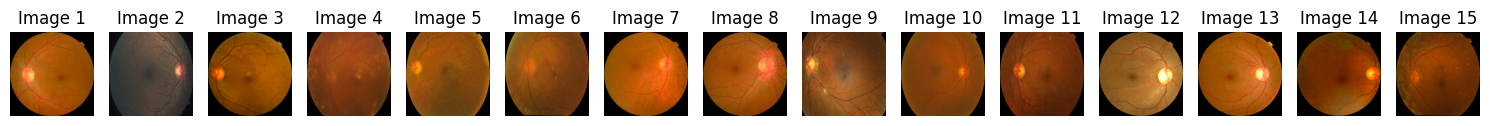

In [ ]:
# plotting the images with applied preprocessing

image_folder = "2019_data/train_images" # folder with 2019 images
image_names = [img for img in os.listdir(image_folder) if img.endswith('.png')]

def show_images(image_paths):
    plt.figure(figsize=(15,10))
    for idx, img_path in enumerate(image_paths, 1):
        plt.subplot(1, len(image_paths), idx)
        image = auto_crop(img_path) # apply auto cropping
        plt.imshow(image)
        plt.title(f"Image {idx}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# apply function on first 5 images
selected_images = [os.path.join(image_folder, name) for name in image_names[5:20]]
show_images(selected_images)

In [ ]:
def createDataloader(preprocessing, transform): # function for creating data loaders for finetuning. Each model in the ensemble will use a different train datalaoder, but same validation dataloader
    finetune_train_dataset = finetuneData(dataframe=train_df, img_dir='2019_data/train_images', preprocessing=preprocessing, transform=transform)
    finetune_train_dataloader = DataLoader(finetune_train_dataset, batch_size=32, shuffle=True)  # Shuffling is generally good for training
    return finetune_train_dataloader

finetune_train_basic_dataloader = createDataloader(standard_preprocessing, augmentations_basic) #basic augmentations and preprocessing dataloader
finetune_train_focus_dataloader = createDataloader(auto_crop, augmentations_focus) #auto crop preprocessing
finetune_train_nopreprocessing_dataloader = createDataloader(None, None) # no preprocessing or augmentations
finetune_train_all_dataloader = createDataloader(standard_preprocessing, augmentations_all) # all augmentations, including contrast, shearing, flipping, etc

We will now train 4 models to form an ensemble whose outputs will be averaged in order to obtain a final prediction. This method will improve the model's robustness and generalizability to deviations in the test data

In [ ]:
basic_model = train_base_model(saved_basemodel_B3, finetune_train_basic_dataloader, finetune_val_dataloader, criterion, optimizerB3_fine_tuning, 15, 'basic_finetuned_model/BestBaseModel.pt', 'basic_finetuned_model/all_checkpoints_trial2', device)

Epoch 0/15 Training Loss: 0.1237 Training Acc: 0.8010
Epoch 0/15 Validation Loss: 0.1164 Validation Acc: 0.8104
Validation loss decreased, saving the model to basic_finetuned_model/BestBaseModel.pt
Epoch 1/15 Training Loss: 0.1180 Training Acc: 0.8044
Epoch 1/15 Validation Loss: 0.1154 Validation Acc: 0.8226
Validation loss decreased, saving the model to basic_finetuned_model/BestBaseModel.pt
Epoch 2/15 Training Loss: 0.1157 Training Acc: 0.8047
Epoch 2/15 Validation Loss: 0.1111 Validation Acc: 0.8240
Validation loss decreased, saving the model to basic_finetuned_model/BestBaseModel.pt
Epoch 3/15 Training Loss: 0.1102 Training Acc: 0.8081
Epoch 3/15 Validation Loss: 0.1107 Validation Acc: 0.8254
Validation loss decreased, saving the model to basic_finetuned_model/BestBaseModel.pt
Epoch 4/15 Training Loss: 0.1027 Training Acc: 0.8337
Epoch 4/15 Validation Loss: 0.1078 Validation Acc: 0.8213
Validation loss decreased, saving the model to basic_finetuned_model/BestBaseModel.pt
Epoch 5/15

In [ ]:
basic_model = copy.deepcopy(saved_basemodel_B3)
basic_optimizer = copy.deepcopy(optimizerB3_fine_tuning)

checkpoint_path = "basic_finetuned_model/all_checkpoints_trial2/model_checkpoint_9.pt"
checkpoint = torch.load(checkpoint_path, map_location = device)

basic_model.load_state_dict(checkpoint['model_state_dict'])
basic_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

val_loss = checkpoint['val_loss']
val_acc = checkpoint['val_acc']

print(val_loss)

0.10221292042919265


In [ ]:
basic_model = train_base_model(basic_model, finetune_train_basic_dataloader, finetune_val_dataloader, criterion, basic_optimizer, 5, 'basic_finetuned_model/BestBaseModel.pt', 'basic_finetuned_model/all_checkpoints_trial2', device, 10)

Epoch 10/5 Training Loss: 0.0977 Training Acc: 0.8371
Epoch 10/5 Validation Loss: 0.1021 Validation Acc: 0.8267
Validation loss decreased, saving the model to basic_finetuned_model/BestBaseModel.pt
Epoch 11/5 Training Loss: 0.0966 Training Acc: 0.8303
Epoch 11/5 Validation Loss: 0.1020 Validation Acc: 0.8267
Validation loss decreased, saving the model to basic_finetuned_model/BestBaseModel.pt
Epoch 12/5 Training Loss: 0.0935 Training Acc: 0.8402
Epoch 12/5 Validation Loss: 0.1019 Validation Acc: 0.8254
Validation loss decreased, saving the model to basic_finetuned_model/BestBaseModel.pt
Epoch 13/5 Training Loss: 0.0991 Training Acc: 0.8385
Epoch 13/5 Validation Loss: 0.1019 Validation Acc: 0.8254
Validation loss decreased, saving the model to basic_finetuned_model/BestBaseModel.pt
Epoch 14/5 Training Loss: 0.0973 Training Acc: 0.8375
Epoch 14/5 Validation Loss: 0.1020 Validation Acc: 0.8281


In [ ]:
focus_model = train_base_model(saved_basemodel_B3, finetune_train_focus_dataloader, finetune_val_dataloader, criterion, optimizerB3_fine_tuning, 15, 'focus_finetuned_model/BestBaseModel.pt', 'focus_finetuned_model/all_checkpoints2', device)

Epoch 0/15 Validation Loss: 0.1698 Validation Acc: 0.7817
Validation loss decreased, saving the model to focus_finetuned_model/BestBaseModel.pt
Epoch 1/15 Training Loss: 0.1693 Training Acc: 0.7562
Epoch 1/15 Validation Loss: 0.1506 Validation Acc: 0.7954
Validation loss decreased, saving the model to focus_finetuned_model/BestBaseModel.pt
Epoch 2/15 Training Loss: 0.1534 Training Acc: 0.7644
Epoch 2/15 Validation Loss: 0.1390 Validation Acc: 0.8131
Validation loss decreased, saving the model to focus_finetuned_model/BestBaseModel.pt
Epoch 3/15 Training Loss: 0.1388 Training Acc: 0.7757
Epoch 3/15 Validation Loss: 0.1319 Validation Acc: 0.8240
Validation loss decreased, saving the model to focus_finetuned_model/BestBaseModel.pt
Epoch 4/15 Training Loss: 0.1383 Training Acc: 0.7767
Epoch 4/15 Validation Loss: 0.1294 Validation Acc: 0.8240
Validation loss decreased, saving the model to focus_finetuned_model/BestBaseModel.pt
Epoch 5/15 Training Loss: 0.1310 Training Acc: 0.7791
Epoch 5/15

In [ ]:
robust_model = train_base_model(saved_basemodel_B3, finetune_train_all_dataloader, finetune_val_dataloader, criterion, optimizerB3_fine_tuning, 15, 'robust_finetuned_model/BestBaseModel.pt', 'robust_finetuned_model/all_checkpoints2', device)

Epoch 0/15 Training Loss: 0.1058 Training Acc: 0.8184
Epoch 0/15 Validation Loss: 0.1065 Validation Acc: 0.8281
Validation loss decreased, saving the model to robust_finetuned_model/BestBaseModel.pt
Epoch 1/15 Training Loss: 0.1052 Training Acc: 0.8259
Epoch 1/15 Validation Loss: 0.1052 Validation Acc: 0.8322
Validation loss decreased, saving the model to robust_finetuned_model/BestBaseModel.pt
Epoch 2/15 Training Loss: 0.1024 Training Acc: 0.8276
Epoch 2/15 Validation Loss: 0.1048 Validation Acc: 0.8267
Validation loss decreased, saving the model to robust_finetuned_model/BestBaseModel.pt
Epoch 3/15 Training Loss: 0.1006 Training Acc: 0.8337
Epoch 3/15 Validation Loss: 0.1043 Validation Acc: 0.8322
Validation loss decreased, saving the model to robust_finetuned_model/BestBaseModel.pt
Epoch 4/15 Training Loss: 0.0984 Training Acc: 0.8296
Epoch 4/15 Validation Loss: 0.1049 Validation Acc: 0.8363
Epoch 5/15 Training Loss: 0.0987 Training Acc: 0.8310
Epoch 5/15 Validation Loss: 0.1047 Val

In [ ]:
nopreprocessing_model = train_base_model(saved_basemodel_B3, finetune_train_nopreprocessing_dataloader, finetune_val_dataloader, criterion, optimizerB3_fine_tuning, 15, 'finetuned_nopreprocessing/BestBaseModel.pt', 'finetuned_nopreprocessing/all_checkpoints2', device)

Epoch 0/15 Training Loss: 0.0703 Training Acc: 0.8781
Epoch 0/15 Validation Loss: 0.1022 Validation Acc: 0.8349
Validation loss decreased, saving the model to finetuned_nopreprocessing/BestBaseModel.pt
Epoch 1/15 Training Loss: 0.0655 Training Acc: 0.8839
Epoch 1/15 Validation Loss: 0.1040 Validation Acc: 0.8417
Epoch 2/15 Training Loss: 0.0643 Training Acc: 0.8907
Epoch 2/15 Validation Loss: 0.1035 Validation Acc: 0.8445
Epoch 3/15 Training Loss: 0.0600 Training Acc: 0.8931
Epoch 3/15 Validation Loss: 0.1041 Validation Acc: 0.8431
Epoch 4/15 Training Loss: 0.0538 Training Acc: 0.9109
Epoch 4/15 Validation Loss: 0.1074 Validation Acc: 0.8404
Epoch 5/15 Training Loss: 0.0530 Training Acc: 0.9051
Epoch 5/15 Validation Loss: 0.1085 Validation Acc: 0.8377
Early Stopping


In [ ]:
def load_checkpoint(model_path, base_model, optimizer): # function to load models from their checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    model = copy.deepcopy(base_model)
    opt = copy.deepcopy(optimizer)

    model.load_state_dict(checkpoint['model_state_dict'])
    opt.load_state_dict(checkpoint['optimizer_state_dict'])

    val_loss = checkpoint['val_loss']
    val_acc = checkpoint['val_acc']

    return model, opt, val_loss, val_acc

def get_best_models(model_path_1, model_path_2, model_path_3, model_path_4): # function to return the best models with learned weights, along with optimizer, val loss and val accuracy
    model_tuple_1 = load_checkpoint(model_path_1, saved_basemodel_B3, optimizerB3_fine_tuning)
    model_tuple_2 = load_checkpoint(model_path_2, saved_basemodel_B3, optimizerB3_fine_tuning)
    model_tuple_3 = load_checkpoint(model_path_3, saved_basemodel_B3, optimizerB3_fine_tuning)
    model_tuple_4 = load_checkpoint(model_path_4, saved_basemodel_B3, optimizerB3_fine_tuning)

    return [model_tuple_1, model_tuple_2, model_tuple_3, model_tuple_4]

The exact checkpoints for the model were chosen based on a combination of lowest loss and highest accuracy. Slight decreases in loss and large increases in accuracy were picked over the lowest loss checkpoint.  

In [ ]:
basic_processing_model, focused_model, robust_model, standard_model = get_best_models('basic_finetuned_model/all_checkpoints_trial2/model_checkpoint_13.pt','focus_finetuned_model/all_checkpoints2/model_checkpoint_12.pt', 'robust_finetuned_model/all_checkpoints2/model_checkpoint_10.pt','finetuned_nopreprocessing/all_checkpoints2/model_checkpoint_2.pt')

In [ ]:
# create a models dictionary which will be used during test time augmentation

models_dict = {
    'basic': basic_processing_model[0],
    'focused': focused_model[0],
    'robust': robust_model[0],
    'standard': standard_model[0]
}

We will split the cross validation set into a CV and test set, as we are optimizing threshold for predictions on the CV set.

In [ ]:
from torch.utils.data import Subset

dataset_length = len(finetune_val_dataset)
split_point = dataset_length // 2

cross_validation_dataset = Subset(finetune_val_dataset, range(0, split_point))
test_dataset = Subset(finetune_val_dataset, range(split_point, dataset_length))

cross_validation_dataloader = DataLoader(cross_validation_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

**Test Time Augmentation Stage**

During TTA, we will apply 4 different flips and rotations to our base images. Each model will have 4 prediction arrays which will be averaged to form a single prediction array from each model. These arrays will be averaged again, and will use the threshold value to pick the predicted class.

In [ ]:
tta_augmentations = [
    A.Compose([A.HorizontalFlip(p=1.0)]),  # Hhrizontal flip
    A.Compose([A.VerticalFlip(p=1.0)]),    # vertical flip
    A.Compose([A.Rotate(limit=(90, 90), p=1.0)]),  # left 90 degrees
    A.Compose([A.Rotate(limit=(-90, -90), p=1.0)]) # right 90 degrees
]

def apply_tta(model, dataloader, transformations): # function to apply test time augmentation to a speciifc model, given either CV or test dataloader
    model.eval()
    all_preds = []

    for tensor_inputs, labels in dataloader:
        tensor_inputs = tensor_inputs.to(device)
        batch_preds = []

        # get original predictions
        with torch.no_grad():
            outputs = model(tensor_inputs)
        batch_preds.append(outputs)

        # get predictions with TTA
        for transform in transformations:
            # convert tensor back to numpy for Albumentations library
            numpy_inputs = tensor_inputs.permute(0, 2, 3, 1).cpu().numpy()

            augmented_images = [transform(image=img)['image'] for img in numpy_inputs]

            augmented_tensors = torch.stack([transforms.ToTensor()(img) for img in augmented_images]).to('cuda')

            with torch.no_grad():
                outputs = model(augmented_tensors)
            batch_preds.append(outputs)

        avg_batch_preds = torch.stack(batch_preds).mean(0) # average the predictions for the 4 different augmentatons
        all_preds.append(avg_batch_preds)

    avg_preds = torch.cat(all_preds, dim=0) # result is a 2D tensor, where each row is a probabilities array

    return avg_preds

In [ ]:
def determine_class(tensor, threshold): # function to determine predicted class, given a singular prediction row tensor
    preds = (tensor > threshold).float()
    return torch.argmax(preds * torch.arange(0, tensor.shape[0], device='cuda'))

def average_predictions(tta_results, threshold): # given 2D tensors for each model's predictions, average the predictions for each sample and determine the final predicted class
    num_samples = tta_results['focused'].shape[0]
    final_predictions = []

    for i in range(num_samples):
        avg_probs = []

        for _, tensor in tta_results.items():
            avg_probs.append(tensor[i])

        avg_tensor = torch.mean(torch.stack(avg_probs), dim=0)

        final_predictions.append(determine_class(avg_tensor, threshold))

    return torch.tensor(final_predictions)

In [ ]:
def loadTrueLabels(dataloader): # load true labels given dataloader
    true_labels = []

    for _, labels in dataloader:
        true_labels.extend(labels.tolist())

    true_labels = torch.tensor(true_labels)

    _, targets = torch.max(true_labels * torch.arange(0,5), dim = 1)

    return targets

def getTTAResults(my_dict, dataloader, augmentations): # creates a dictionary of test time augmentation results, given the dataloader and albumentations augmentations array
    tta_results = {}
    for model_name, actual_model in my_dict.items():
        tta_predictions = apply_tta(actual_model, dataloader, augmentations)
        tta_results[model_name] = tta_predictions
    return tta_results

In [ ]:
def findOptimalThreshold(my_dict, dataloader, thresholds, augmentations): # find threshold value that yields highest accuracy, optimized on CV set
    tta_results = getTTAResults(my_dict, dataloader, augmentations)

    best_threshold = 0
    best_score = 0

    for thresh in thresholds:
        predictions = average_predictions(tta_results, thresh) # get predictions from TTA
        true_labels = loadTrueLabels(dataloader) # get true labels
        score = torch.mean((predictions == true_labels).float()) # calculate accuracy
        if score > best_score:
            best_threshold = thresh

    return best_threshold

possible_thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

optimal_threshold = findOptimalThreshold(models_dict, cross_validation_dataloader, possible_thresholds, tta_augmentations)

print(optimal_threshold)

0.6


Finally, we will use the above functions to return the results of TTA on the rest set, find the accuracy of these predictions by obtaining the true labels, and plot the confustion matrix to view prediction accuracies/inaccuracies.

In [ ]:
test_targets = loadTrueLabels(test_dataloader)

Test accuracy score: 0.8583106398582458


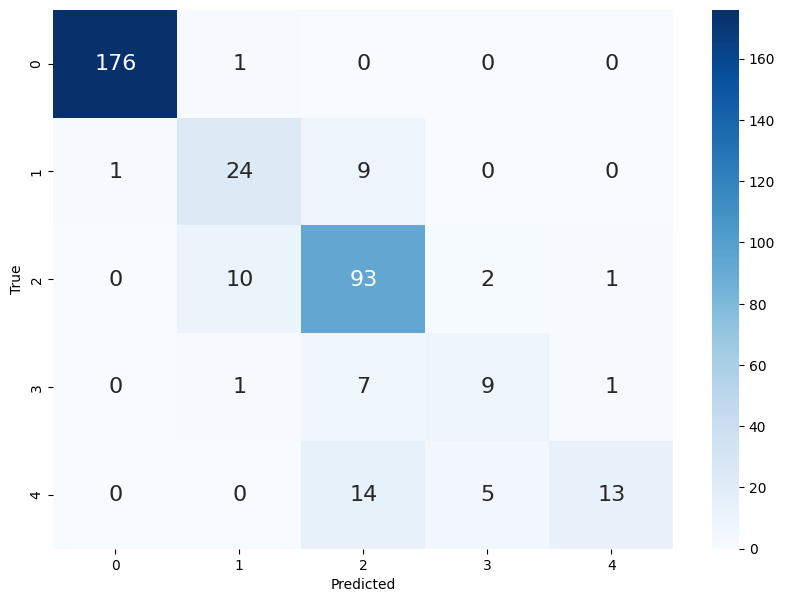

In [ ]:
test_tta_results = getTTAResults(models_dict, test_dataloader, tta_augmentations)

test_predictions = average_predictions(test_tta_results, 0.6)

test_accuracy_score = torch.mean((test_predictions == test_targets).float())

# confusion matrix
test_conf_matrix = confusion_matrix(test_targets, test_predictions)

print('Test accuracy score: {}'.format(test_accuracy_score))

plt.figure(figsize=(10, 7))
sns.heatmap(test_conf_matrix, annot=True, annot_kws={"size": 16}, cmap="Blues", fmt='g')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

We were able to achieve a test set accuracy of about **86%**. As we can see, our model does an outstanding job in classifying the class of 0 (no diabetic retinopathy). It often incorrectly predicts 1 (mild) for true class 2 (severe) as well as 3 for true class 4, which is most likely related to the number of samples present in the training data for each class. To improve, our augmentations could be saved as completely new images, instead of applying it to every image based on a probability. This would generate more samples and perhaps lead to better performance.